## Intro
We will be using the 'bag-of-words' approach, vectorising each review, weighting with tf-idf and reducing with chi-squared. Following, extra pre-processing steps will be used in an attempt to improve the strongest model.

#### Conclusions
SVM proves stronger than Naive Bayes, and works best using chi-squared feature reduction without oversampling or lemmatisation with ~0.78 accuracy. Predictions are far less accurate on the less represented classes.

#### Sections:
1. Exploration: first section exploring the data and labels a little.
2. Preprocessing: removing any uneccessary data and splitting the dataset.
3. First classification: fitting Naive Bayes and a Linear SVM, vectorising with tf-idf and reducing dimensionality with chi-Square.
4. Fitting a new SVM classifer using some extra text processing.
5. SVM with Synthetic Oversampling.
6. SVM Classifier with Lemmatisation (SpaCy).

I've used bullet points for my interpretations in the markdown sections, just incase you're wondering why some use bullets and others don't.

In [1]:
import numpy as np
import pandas as pd
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2 
from sklearn.pipeline import Pipeline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import string
from imblearn.over_sampling import SMOTE
import spacy


with open('data/labelled_dataset.pickle', 'rb') as d:
    data = pickle.load(d)

### 1. Exploration
Let's see if there's anything we need to think about before we split the dataset.

In [2]:
data.head()

,text,labelmax
0,Pros - The people who work here are brilliant ...,customer
1,Pros Start-up vibes Fast growing company Tech-...,customer
2,"Pros The team is great, I love the ambition of...",collaboration
3,"Pros The company is constantly growing, and at...",adaptability
4,Pros Cool office. Friendly people. Good atmosp...,collaboration


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91580 entries, 0 to 91579
Data columns (total 2 columns):
text        91580 non-null object
labelmax    91580 non-null object
dtypes: object(2)
memory usage: 1.4+ MB


In [4]:
cross_lab = pd.crosstab(index=data['labelmax'], columns='count')
cross_lab['pc_of_total'] = round(cross_lab['count']/data['labelmax'].count()*100,0)
cross_lab

col_0,count,pc_of_total
labelmax,,
adaptability,17204,19.0
collaboration,21067,23.0
customer,26981,29.0
detail,4030,4.0
integrity,2815,3.0
null,535,1.0
result,18948,21.0


- So we can see there isn't a clear balance issue here, but it would be nice to slit a training set that shows a similar distribution. It would be optimal if the classifier could distinguish the less populus labels, eg. 'detail', 'integrity' and 'null', which it won't be able to do if there arn't enough of those in the training set.
- We could just use the whole 'labelled_dataset' to train the classifier to be used on the 'unlabelled' set, but then of course we wouldn't be able to test accuracy before doing so.

In [5]:
pd.set_option('display.max_colwidth', 1)
data[data['labelmax']=='null'].head()

,text,labelmax
288,"Pros Auch wenn HelloFresh schon lange kein Start-up mehr ist, hat man oft noch die typisch ""dynamische"" Atmosphäre mitbekommen. Mich persönlich motiviert das. Cons Von meiner Seite aus keine Kontras.",null
295,"Pros Vorgesetzte vertrauen einem, persönliche Weiterentwicklung, offene Arbeitsatmosphäre. Cons Manchmal wird zu lange diskutiert, ehe entschieden wird.",null
296,Pros Die Arbeitsatmosphäre ist offen und angenehm. Frühstück und Getränke werden bereitgestellt. Kurze Entscheidungswege und sehr flache Hierarchie. Cons Ab und an funktioniert das Internet nicht.,null
449,"Pros The day I left, seriously. Cons Everything, everything, everything, everything and everything",null
923,"Pros Mitglied der IG-Metall, gutes Gehalt, zusätzliche Leistungen wie Altersvorsorge Cons Sehr von Umstrukturierung geplagtes Unternehmen - momentan Stellenabbau",null


- So the main concerns for building the model are the high number of 'null' and German reviews.

- Most of the nulls are allocated to reviews that carry no insight, eg. 'No downsides'(id=8603), or where it's too hard to pinpoint a single label (catchphrases might also be too difficult to interpret), for example 'Pros All the resources in the world Cons Too many cooks in the kitchen'(id=8701) might be customer, detail or adaptability related.
- We should keep the 'null' labels so the classifier knows what to call reviews if they don't fit with other labels.

Lets see how many reviews are in German.

In [6]:
german_vowels = ['ä','ü','ö']
cross_ger = pd.crosstab(index=data['labelmax'][data['text'].str.contains('|'.join(german_vowels))], columns='count')
cross_ger

col_0,count
labelmax,
adaptability,260
collaboration,348
customer,676
detail,100
integrity,41
null,335
result,243


- A quick and dirty method, but we can see there are German reviews under each label.

What are these as a percentage of overall reviews?

In [7]:
cross_ger['pc'] = round((cross_ger['count'] / cross_lab['count'])*100,0)
cross_ger

col_0,count,pc
labelmax,,
adaptability,260,2.0
collaboration,348,2.0
customer,676,3.0
detail,100,2.0
integrity,41,1.0
null,335,63.0
result,243,1.0


- It looks like it's a pretty even split aside from the 'null' label. So perhaps either the original classification method is poor at interpreting German reviews, or a much higher proportion of reviews in German carry no real insight.

### 2. Preprocessing
Next we need to split our train and test datasets and vectorise the 'text' column to retrieve features for the classifier. But first, we will remove the German reviews. They are far fewer in qunatity, most of them are 'null' and tf-idf will only be able to account for English stop-words ('a','the' etc.).

In [8]:
# remove reviews with german vowels
data = data[~data['text'].str.contains('|'.join(german_vowels))]
data.shape

(89577, 2)

Convert all text to lower-case

In [9]:
data['text'] = data['text'].str.lower()

Splitting into test and train sets.

In [10]:
# Splitting data into train and test 
from sklearn.model_selection import train_test_split
X = data['text']
y = data['labelmax']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

sklearn should evenly split based on labels, but we can easily double-check.

In [11]:
cross_train = pd.crosstab(index=y_train, columns='count')
cross_train['pc_of_total'] = round(cross_train['count']/y_train.count()*100,0)
cross_train['diff_from_pop'] = cross_lab['pc_of_total'] - cross_train['pc_of_total'] 
cross_train

col_0,count,pc_of_total,diff_from_pop
labelmax,,,
adaptability,13571,19.0,0.0
collaboration,16599,23.0,0.0
customer,21010,29.0,0.0
detail,3129,4.0,0.0
integrity,2214,3.0,0.0
null,171,0.0,1.0
result,14967,21.0,0.0


- We seem to have a closely comparable distribution for the training sample vs. the full dataset so we're good to go.

### 3. First Classification
Now we have our features, it's time to build the classifier. In this instance we will be comparing multinomial naive bayes and linear support vector classifier, tuning the most effective model.
- TfidfVectorizer will first create count vectors, then tf-idf will adjust weights for stop-words and comment length.
- sublinear_tf means higher word frequency weights increase logorithmically, not absolute.
- chi2 reduces our features to the most significant according to chi-squared test (5k words apparently a sweet spot after a little trial and error), thus helping remove usless words.
- n_grams is commonly used parameter for tf-idf, but the extra meaning it gives doesn't improve the models in this case.

In [12]:
# naive bayes classifier
NB_classifier = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                       ('chi', SelectKBest(chi2, k=5000)),
                       ('clf', MultinomialNB())])

# svm classifier
SVC_classifier = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                       ('chi', SelectKBest(chi2, k=5000)),
                       ('clf', LinearSVC(random_state=2))])

# fitting both classifiers to training data
NB_classifier.fit(X_train, y_train)
SVC_classifier.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
 ..., max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=2, tol=0.0001,
     verbose=0))])

In [13]:
# create predicted values using classifiers
NB_pred = NB_classifier.predict(X_test)
SVC_pred = SVC_classifier.predict(X_test)

# % of successful predictions for model accuracy
NB_accu = np.mean(NB_pred == y_test)
SVC_accu = np.mean(SVC_pred == y_test)

(NB_accu,SVC_accu)

(0.5394061174369279, 0.77779638312123245)

- The SVM performed better, so we will ignore the NB classifier in our next iterations.

Let's see where the SVM model is making the mistakes.

In [14]:
classes = list(data['labelmax'].unique())


def confusion_vis(cm, classes, title):
    '''visualising a normalised confusion matrix using example from sklearn docs'''
    # normalise the numbers for easier comparison
    cm = cm.astype('float') / cm1.sum(axis=1)[:, np.newaxis]
    # visualisation
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    # making the number labels readable
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

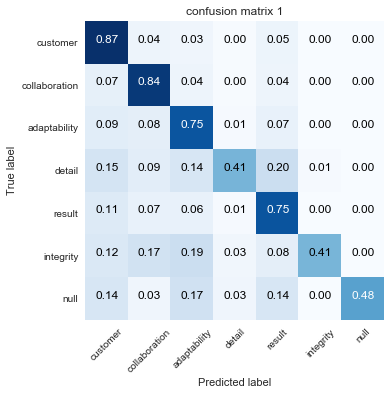

In [15]:
# create confusion matrix for SVM model
cm1 = confusion_matrix(y_test, SVC_pred, classes)

plt.figure()
confusion_vis(cm1, classes, title='confusion matrix')
plt.show()

- It's clear the model is under-predicting the classes with the fewest observations in the training set ('detail', 'integrity').

Now we will take some steps to see if we can improve model accuracy and performance. First, seeing if the text should be cleaned further, followed by oversampling to avoid under-predicting the minority classes.

### 4. Fitting a new SVM classifer using some extra text processing
Let's see if the classifier works better if we clean-up the text a bit further.
Extra steps:
1. Removing punctuation
2. All to lower case
3. Removing standard Glassdoor headings ('pros','cons','advice')

In [16]:
# Punctuation wont add anything to our model in our case, 
# so lets remove that (bare in mind that string.puncutation() can only be used on English text).
def no_punc(review):
    for punc in string.punctuation:
        review = review.replace(punc, '')
    return review

# create copy of data (German reviews have already been removed)
data2 = data.copy()
data2['text'] = data2['text'].apply(no_punc)

# We also have the headings for the sections that break-up each glassdoor review (pros,cons..etc.), 
# so even though they should get filtered out with the chi-squared method later, we can nip it in the bud right now. 
headings = ['pros','cons','advice to management']

def remove_headings(review):
    for heading in headings:
        review = review.replace(heading, '')
    return review

data2['text'] = data2['text'].apply(remove_headings)

# quick glance to see if the text is as expected
data2.head(2)

,text,labelmax
0,the people who work here are brilliant intelligent hardworking etc exciting career opportunities plenty of room to grow great company culture social events etc management really value everyones opinion and are open to ideas ambitious company always working to grow and improve i feel like my work is really valued and outstanding performance is always recognised by management salary isnt great compared to other grad jobs hopefully this will improve as the company grows occasionally have to work weekends would much rather there was a separate weekend team communication could be better about changes in the company future plans etc keep listening to your employees dont become cold and corporate airsorted needs to keep the company spirit even when it is a big global company,customer
1,startup vibes fast growing company techoriented lively atmosphere the managers are down to earth managers are open to ideas from all employees young and friendly colleagues fun social outings ambitious company not the best pay hopefully this will increase soon as the company grows communications across teams could improve,customer


- The new text looks like it's cleaned as expected.

Running through the same process as before to get our new classifier up and running.

In [17]:
X2 = data2['text']
y2 = data2['labelmax']

# splitting the new dataframe
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=2)

Fitting the new SVM classifier.

In [18]:
# new svm classifier
SVC_classifier2 = Pipeline([('tfidf2', TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                       ('chi', SelectKBest(chi2, k=5000)),
                       ('clf', LinearSVC(random_state=2))])

SVC_classifier2.fit(X_train2, y_train2)
SVC_test_pred2 = SVC_classifier2.predict(X_test2)

Do we manage a better score?

In [19]:
SVC_accu2 = np.mean(SVC_test_pred2 == y_test2)
SVC_accu2

0.75982362134405002

- The score is a little lower, so we may have cleaned the text a bit too much in this instance. 

### 5. SVM with Synthetic Oversampling

Recall from the original exploration there were far fewer cases of the 'detail' and 'integrity' classes, causing the SVM model to under-predict these in our test set.

We will create synthetic observations to bring the ratio up to 1, and see if the improved balance reflects in the model. SMOTE does this by finding k-nearest-neighbours of the minority classes, randomly choosing one to tweak into a new observation.

A couple of things to note here:
- Must be careful to only oversample on training data to avoid leaking perfect matches into the test set.
- SMOTE needs the train and test sets to be vectorised before fit and predict.

In [20]:
# Our new pipeline, which only vectorizes and cleans (chi2)
pipe = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True)),
                       ('chi', SelectKBest(chi2, k=5000))])

# vectorize the entire dataset and split 
# unlike our previous models, the classifier must use floats for predictions once oversampled
X_vec = pipe.fit_transform(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=2)

In [21]:
# fitting the oversample to training set
sm = SMOTE(random_state=2, ratio=1.0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

C:\Users\Oliver\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Let's check if it worked.

In [22]:
pd.crosstab(index=y_train_res, columns='count')

col_0,count
row_0,
adaptability,21010
collaboration,21010
customer,21010
detail,21010
integrity,21010
null,21010
result,21010


- All 'minority' classes now have synthetic observations which bring their counts up to the largest class 'customer'.

In [23]:
# the new classifier
SVC_clf = LinearSVC(random_state=2)
SVC_clf.fit(X_train_res, y_train_res)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=2, tol=0.0001,
     verbose=0)

In [24]:
SVC_clf.score(X_test, y_test)

0.75625139540075914

- A poorer score than the original.
- The process here is not particularly practical in real-world scenarios: the unseen data must come in the same shape as training set, ie. we must preempt words that will be used in the future.

### 6. SVM Classifier with Lemmatisation
It's highly likely that the 'bag-of-words' that we have created includes inflection forms of words. So we might have 3 features: adapt, adaptable, adaptability; when it would be helpful to have only 1 in this instance so the tf-idf vectoriser can more accurately weight the feature. 

##### Lemmatisation vs Stemming 
- Stemming approaches each word exclusively, cutting off the ends to get something like 'adapt' in this case; whereas Lemmatisation is a network of English words, which allows the method to consider the context before replacing anything. 
- Intuitively we might not care if our method reduces [adapt, adaptable, adaptability] to gibberish like 'adap', because we still reduce the 3 features to 1. But, what if it reduces 'adaptor' to 'adap' as well? That's where Lemmatisation might improve on the stemmer approach in our case.


Let's see if using a lemmatiser makes a difference.

In [25]:
data4 = data.copy()
data4.head(1)

,text,labelmax
0,"pros - the people who work here are brilliant (intelligent, hard-working etc.) - exciting career opportunities, plenty of room to grow! - great company culture, social events etc. - management really value everyone's opinion and are open to ideas - ambitious company, always working to grow and improve - i feel like my work is really valued, and outstanding performance is always recognised by management cons - salary isn't great compared to other grad jobs, hopefully this will improve as the company grows - occasionally have to work weekends, would much rather there was a separate weekend team - communication could be better about changes in the company, future plans etc. advice to management - keep listening to your employees - don't become cold and corporate. airsorted needs to keep the company spirit, even when it is a big global company.",customer


In [26]:
nlp = spacy.load('en')

# filter out the tokens we don't want to lemmatise using 
def token_filter(token):
    return not (token.is_punct | token.is_space | token.is_stop | len(token.text) <= 4)

%time data4['lam_text'] = data4['text'].apply(lambda row: [w.lemma_ for w in nlp.tokenizer(row) if token_filter(w)])


Wall time: 4min 19s


- One thing to note on speed: use nlp.tokenizer to access the lemmatizer tokens, otherwise the nlp object here runs the entire SpaCy pipeline.

Let's see how our first review looks now.

In [27]:
data4.head(1)

,text,labelmax,lam_text
0,"pros - the people who work here are brilliant (intelligent, hard-working etc.) - exciting career opportunities, plenty of room to grow! - great company culture, social events etc. - management really value everyone's opinion and are open to ideas - ambitious company, always working to grow and improve - i feel like my work is really valued, and outstanding performance is always recognised by management cons - salary isn't great compared to other grad jobs, hopefully this will improve as the company grows - occasionally have to work weekends, would much rather there was a separate weekend team - communication could be better about changes in the company, future plans etc. advice to management - keep listening to your employees - don't become cold and corporate. airsorted needs to keep the company spirit, even when it is a big global company.",customer,"[people, here, brilliant, intelligent, work, excite, career, opportunity, plenty, great, company, culture, social, event, management, really, value, everyone, opinion, idea, ambitious, company, always, work, improve, really, value, outstanding, performance, always, recognise, management, salary, great, compare, other, hopefully, this, will, improve, company, grow, occasionally, have, weekend, would, much, rather, there, separate, weekend, communication, can, well, about, change, company, future, plan, advice, management, keep, listen, your, employee, become, corporate, airsorted, need, keep, company, spirit, even, when, global, company]"


Good, next we need to split and run the classifier.

In [28]:
# split 
X4 = data4['lam_text']
y4 = data4['labelmax']

X_train4, X_test4, y_train4, y_test4 = train_test_split(X4, y4, test_size=0.2, random_state=2)

In [35]:
# dummy function for tfidf to accept pre-tokenized reviews
def dummy(doc):
    return doc

# fresh pipeline with tokenizer and preprocessor taking the pre-tokenized reviews
SVC_classifier4 = Pipeline([('tfidf', TfidfVectorizer(stop_words='english', sublinear_tf=True, tokenizer=dummy, preprocessor=dummy)),
                            ('chi', SelectKBest(chi2, k=5000)),
                            ('clf', LinearSVC(random_state=2))])

In [36]:
SVC_classifier4.fit(X_train4, y_train4)

Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2',
        preprocessor=<function dummy ..., max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=2, tol=0.0001,
     verbose=0))])

In [34]:
SVC_classifier4.score(X_test4, y_test4)

0.6542755079258763

- Our model has become considerably less accurate. 

Let's have a quick look to see what's changed per class.

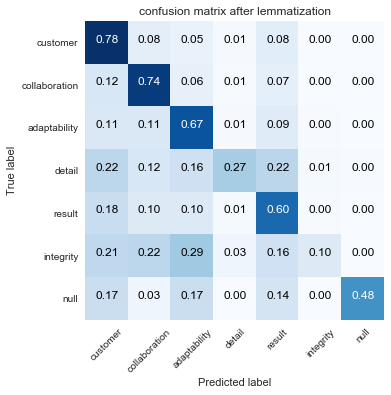

In [37]:
SVC_pred4 = SVC_classifier4.predict(X_test4)

# create confusion matrix for SVM model
cm2 = confusion_matrix(y_test4, SVC_pred4, classes)

plt.figure()
confusion_vis(cm2, classes, title='confusion matrix after lemmatization')
plt.show()